## Interaction between pricing and bidding algorithms in adversarial environment

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define environments and agents classes

In [2]:
# First Price Auction
class FirstPriceAuction:
    def __init__(self, bids_per_slot):
        self.bids_per_slot = bids_per_slot

    def round(self, bids):
        winners = np.argmax(bids)
        payments_per_click = np.sort(bids)[-2]  # Second highest bid
        return winners, payments_per_click

In [3]:
# Hedge Agent
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K) / K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate * l_t)
        self.t += 1

In [4]:
# Pricing Environment
class PricingEnvironment:
    def __init__(self, price_sequence, buy_probability_functions, cost):
        self.price_sequence = price_sequence
        self.buy_probability_functions = buy_probability_functions
        self.cost = cost
        self.t = 0

    def round(self, p_t, n_t): # p_t is price, n_t is the number of people who see the product. t is the round
        d_t = np.random.binomial(n_t, self.buy_probability_functions[self.t](p_t))
        r_t = (p_t - self.cost) * d_t # r_t is the profit
        self.t += 1
        return d_t, r_t

In [5]:
# EXP3 Agent
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K) / K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t / self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate * l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [6]:
# Full-Feedback Multiplicative Pacing Agent
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K) / T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget / self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]
    
    def update(self, f_t, c_t, m_t):
        f_t_full = np.array([(self.valuation - b) * int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b * int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd * (c_t_full - self.rho)
        range_L = 2 + (1 - self.rho) / self.rho
        self.hedge.update((2 - L) / range_L)
        self.lmbd = np.clip(self.lmbd - self.eta * (self.rho - c_t), a_min=0, a_max=1 / self.rho)
        self.budget -= c_t

Useful functions

In [7]:
# Function to simulate buy probability as a function of price
def buy_probability_function(price, t):
    base_prob = np.clip(1 - price, 0, 1)  # simple linear decreasing function of price
    # Add high-frequency components for non-stationarity
    time_variation = 0.5 + 0.5 * np.sin(0.1 * t) + 0.5 * np.sin(0.5 * t)
    return np.clip(base_prob * time_variation, 0, 1)

In [8]:
# Get the best arm in hindsight as the clairvoyant arm
def get_clairvoyant_arm(n_customers, price_sequence, buy_probability_functions, T, cost):
    reward_function = lambda price, n_sales: (price - cost) * n_sales
    total_losses = []
    for price in price_sequence:
        losses_price = []
        for t in range(T):
            # massimo profitto specifico per questo giorno
            profit_curve = reward_function(price_sequence, n_customers * buy_probability_functions[t](price_sequence))
            optimal_price_index = np.argmax(profit_curve)
            optimal_profit = profit_curve[optimal_price_index]

            # profitto del prezzo selezionato
            conversion_probability = buy_probability_functions[t](price)
            n_sales = n_customers * conversion_probability
            profit = (price - cost) * n_sales
            
            # loss giornaliera
            loss = optimal_profit - profit
            losses_price.append(loss)
        
        total_loss_price = np.sum(losses_price)
        total_losses.append(total_loss_price)
    
    clairvoyant_arm_index = np.argmin(total_losses)
    clairvoyant_arm = price_sequence[clairvoyant_arm_index]

    return clairvoyant_arm

In [9]:
def get_clairvoyant_non_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation - m_t) * (my_valuation >= m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility))  # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids = np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0  # Cumulative cost 
    i = 0
    while c <= B - 1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i += 1
    clairvoyant_bids = clairvoyant_bids * m_t
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

Simulation

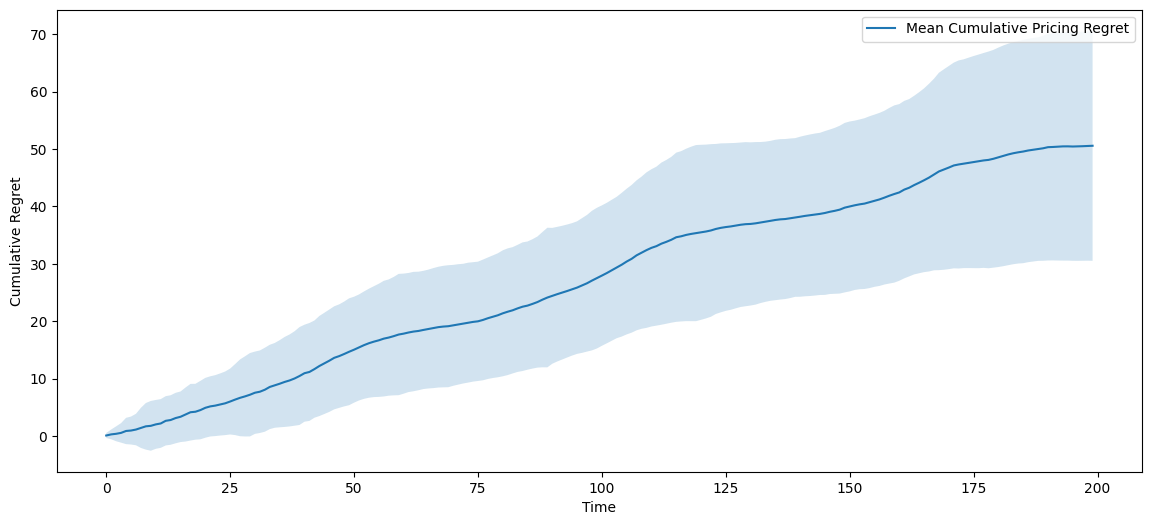

Price chosen by the clairvoyant in hindsight: 0.5555555555555556
Mean Final Pricing Regret: 50.555555555555536 ± 20.027191392247904


In [10]:
# Set parameters
T = 200  # days
K = 10  # discrete prices
cost_per_unit = 0.1  # cost per unit sold
num_iterations = 50  # number of iterations for different seeds
n_advertisers = 3
n_users = 200
B = 500
my_valuation = 5
rho = B / n_users
P = 10  # Frequency of price update
max_customers = 10  # maximum number of customers

# Initialize arrays to store regrets
pricing_regret_list = []

# Iterate over different seeds
for iteration in range(num_iterations):
    # Set seed for reproducibility
    np.random.seed(iteration)

    # Generate highly non-stationary buy probability functions
    price_sequence = np.linspace(0, 1, K)
    buy_probability_functions = [lambda p, t=t: buy_probability_function(p, t) for t in range(T)]

    # Initialize environments
    pricing_env = PricingEnvironment(price_sequence, buy_probability_functions, cost_per_unit)

    # Initialize agents
    learning_rate = np.sqrt(np.log(K) / (K * T))
    pricing_agent = EXP3Agent(K, learning_rate)

    # Compute clairvoyant arm
    clairvoyant_arm = get_clairvoyant_arm(max_customers, price_sequence, buy_probability_functions, T, cost_per_unit)

    # Auction-related variables
    pattern = lambda t: 1 - np.abs(np.sin(5 * t / n_users))
    other_bids = np.array([np.random.uniform(0, pattern(t), size=n_advertisers) for t in range(n_users)]).T
    m_t = other_bids.max(axis=0)

    available_bids = np.linspace(0, 1, 11)
    win_probabilities = np.array([sum(b > m_t) / n_users for b in available_bids])

    expected_clairvoyant_bids, expected_clairvoyant_utilities, expected_clairvoyant_payments = get_clairvoyant_non_truthful(B, my_valuation, m_t, n_users)
    
    agent = FFMultiplicativePacingAgent(available_bids, my_valuation, B, n_users, 1 / np.sqrt(n_users))
    utilities = []
    budgets = []
    bids = []

    for t in range(n_users):
        b_t = agent.bid()
        winners, m_t = FirstPriceAuction(n_advertisers).round(other_bids[:, t])
        f_t = my_valuation - m_t if b_t > m_t else 0
        c_t = m_t if b_t > m_t else 0
        agent.update(f_t, c_t, m_t)
        utilities.append(f_t)
        budgets.append(agent.budget)
        bids.append(b_t)

    # Initialize auctions environment
    auction_env = FirstPriceAuction(n_advertisers)
    
    # Initialize auctions agents
    auction_agents = [FFMultiplicativePacingAgent(available_bids, my_valuation, B, n_users, 1 / np.sqrt(n_users)) for _ in range(n_advertisers)]
    
    # Run the combined algorithm
    clairvoyant_losses = []
    pricing_losses = []
    auction_utilities = []
    for t in range(T):
        # Pricing step (every P days)
        if t % P == 0:
            price_arm = pricing_agent.pull_arm()
            price = price_sequence[price_arm]

        # Auction step
        auction_bids = [agent.bid() for agent in auction_agents]
        winners, payment_per_click = auction_env.round(auction_bids)
        
        # Number of customers seeing the price depends on the auction result
        n_customers = np.random.poisson(5) if winners == 0 else np.random.poisson(1)

        # If the company wins an auction slot, calculate revenue and update budget
        if winners == 0:
            d_t, r_t = pricing_env.round(price, n_customers)
            for agent in auction_agents:
                f_t = my_valuation - payment_per_click if agent.bid() > payment_per_click else 0
                c_t = payment_per_click if agent.bid() > payment_per_click else 0
                agent.update(f_t, c_t, payment_per_click)
            auction_utilities.append(f_t)
        else:
            d_t, r_t = 0, 0
        
        # Compute the optimal profit for this time step
        optimal_profit = max((price_sequence - cost_per_unit) * max_customers * buy_probability_functions[t](price_sequence))

        # Calculate the clayrvoiant loss
        clairvoyant_profit = (clairvoyant_arm - cost_per_unit) * d_t
        clairvoyant_loss = optimal_profit - clairvoyant_profit
        clairvoyant_losses.append(clairvoyant_loss)

        # Calculate the instantaneous loss
        agent_loss = optimal_profit - r_t
        pricing_losses.append(agent_loss)

        # Update the agent
        pricing_agent.update(agent_loss)
    
    cumulative_clairvoyant_losses = np.cumsum(clairvoyant_losses)
    cumulative_pricing_losses = np.cumsum(pricing_losses)
    
    # Compute cumulative regret
    cumulative_pricing_regret = cumulative_pricing_losses - cumulative_clairvoyant_losses

    # Store regrets
    pricing_regret_list.append(cumulative_pricing_regret)

# Convert lists to arrays for easier manipulation
pricing_regret_array = np.array(pricing_regret_list)

# Compute mean and standard deviation of cumulative regret
mean_pricing_regret = np.mean(pricing_regret_array, axis=0)
std_pricing_regret = np.std(pricing_regret_array, axis=0)

# Plot cumulative regret
plt.figure(figsize=(14, 6))
plt.plot(mean_pricing_regret, label='Mean Cumulative Pricing Regret')
plt.fill_between(range(T), mean_pricing_regret - std_pricing_regret, mean_pricing_regret + std_pricing_regret, alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.show()

print(f'Price chosen by the clairvoyant in hindsight: {clairvoyant_arm}')
print(f'Mean Final Pricing Regret: {mean_pricing_regret[-1]} ± {std_pricing_regret[-1]}')


Check convergence

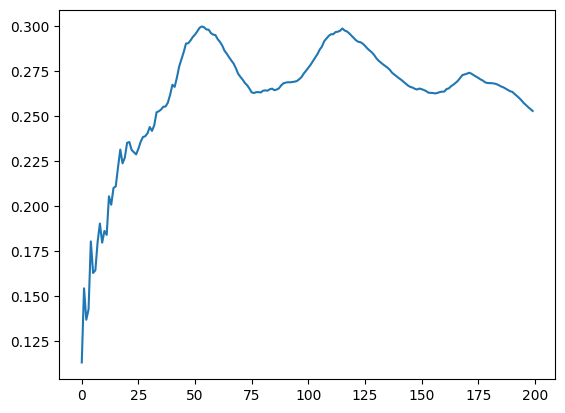

In [11]:
mean_cumulative_regret = mean_pricing_regret/np.arange(1,T+1)
plt.plot(mean_cumulative_regret)

# no convergence with 200 rounds
# yes convergence with 10k rounds